In [26]:
using Random, StatsBase, Plots

# Las ocho reinas

El problema de las ocho reinas consiste en colocar ocho reinas en un tablero de ajedrez si que se puedan capturar entre sí en un movimiento. El problema fue propuesto en 1848 por Max Bezzel. Tiene 92 posibles soluciones, contando reflexiones y rotaciones.

Considere una solución con las siguientes características

* Representación: Permutación
* Recombinación: `cut & crossfit` con probabilidad 1
* Mutación: `swap` con probabilidad 0.8
* Selección de padres: mejores 2 de 5 aleatorios
* Operador de reemplazo: reemplazar a los peores
* Tamaño de la población: 100 individuos
* Inicialización: Aleatoria
* Condición de paro: Encontrar la solución o evaluación de 10,000 fitness.

A partir del planteamiento realizado en clase, resolver este problema a través
de algoritmos evolutivos.

* Reporte la solución: genotipo, fenotipo y fitness.
* Grafique la evolución de la mejor aptitud y fitness promedio.
* Con su implementación resuelva el problema para $n=30$ reinas.

## Modelación

### Genotipo

Cada permutación se representa como una lista de enteros, de tal manera que $q[i]$ representa el lugar a donde se permuteó la posición $i$.

In [2]:
const Queen = Array{Int, 1}

Array{Int64,1}

### Fenotipo

El fenotipo de la permutación sería el tablero asociado. En este caso, los fenotipos se representan como matrices con entrada $0$ para casillas vacías y $1$ para casillas con una reina. 

In [3]:
function build_board(q::Queen)::Array{Int, 2}
    n = length(q)
    board::Array{Int, 2} = zeros((n, n))
    for (x, y) in enumerate(q)
        board[x, y] = 1
    end
    return board
end

build_board (generic function with 1 method)

### Aptitud

Una medidad del desempeño puede ser la cantidad de colisiones que tiene una reinas con todas las demás. Esta cantidad se quiere hacer cero, así que la aptitud se puede tomar como el recíproco de esta cantidad. 

Notemos que como los genotipos son permutaciones, no es posible que en fenotipo haya dos reinas en la misma fila o columna. Así que las únicas colisiones serían por diagonales.

In [4]:
function collisions(q::Queen)::Int
    total = 0
    for i in 1:length(q)
        for j in 1:(i-1)
            offset = i - j
            if q[j] + offset == q[i] || q[i] + offset == q[j]
                total+=1
            end
        end
    end
    return total
end

apt(q::Queen)::Float64 = 1/collisions(q)

apt (generic function with 1 method)

### Reproducción

Primero, se crea una estructura para guardar las probabilidades de mutación y cruza, la población y un generador de números aleatorios. Además se definie el constructor que inicializa una población aleatoria.

In [5]:
const Population = Array{Queen, 1}

mutable struct QueenSGA
    cross_p::Float64
    mut_p::Float64
    pop::Population
    rng::AbstractRNG
    function QueenSGA(n::Int, pop_size::Int, cross_p::Float64, mut_p::Float64, seed=0) 
        r = MersenneTwister(seed)
        init_pop = [randperm(r, n) for i in 1:pop_size]
        new(cross_p, mut_p, init_pop, r)
    end
end

Luego, para la selección de padres se toman los mejores dos de cinco aleatorios

In [6]:
function selection(q::QueenSGA)::Tuple{Queen, Queen}
    p_par = sample(q.rng, q.pop, 5)
    apts = apt.(p_par)
    order = sortperm(apts)
    return (p_par[order[1]], p_par[order[2]])
end

selection (generic function with 1 method)

Para el operador de cruza, se utiliza el método de `cut & crossfit`. Este consta en tomar dos permutaciones y un punto arbitrario de estas (`cut`). Luego, la primera parte del primer padre es completada usado el inicio del segundo padre y viceversa (`crossfit`). Esto da lugar a dos permutaciones nuevas.

In [12]:
function crossfit(c::Queen, p::Tuple{Queen, Queen})::Queen
    i = 1
    while(length(c) < length(p[1]))
        if !(p[2][i] in c)
            push!(c, p[2][i])
        elseif !(p[1][i] in c)
            push!(c, p[1][i])
        end
        i+=1
    end
    return c
end

function cut_and_crossfit(q::QueenSGA, p::Tuple{Queen, Queen})::Tuple{Queen, Queen}
    if rand(q.rng) < q.cross_p
        cut_point = rand(q.rng, 1:length(p[1]))
        c1 = p[1][1:cut_point]
        c2 = p[2][1:cut_point]
    
        return (crossfit(c1, p), crossfit(c2, (p[2], p[1])))
    end
    return p
end

cut_and_crossfit (generic function with 1 method)

Para el operador de mutación se hará un intercambio de elementos de la lista.

In [8]:
function mutation(sga::QueenSGA, q::Queen)::Queen
    if rand(sga.rng) < sga.mut_p
        n = length(q)
        i = rand(sga.rng, 1:n)
        j = rand(sga.rng, 1:n)
        aux = q[i]
        q[i] = q[j]
        q[j] = aux
    end
    return q
end

mutation (generic function with 1 method)

Y para el operador de remplazo, se crearán $n+2$ nuevos individuos, de los que se conservarán los mejores $n$.

In [9]:
function replacement(q::QueenSGA)::Population
    n = length(q.pop)
    n_pop = []
    for i in 1:n
        p = selection(q)
        crs = cut_and_crossfit(q, p)
        m1 = mutation(q, crs[1])
        m2 = mutation(q, crs[2])
        push!(n_pop, m1)
        push!(n_pop, m2)
    end
    ranking = sortperm([apt(s) for s in q.pop])
    return n_pop[ranking[1:n]]
end

replacement (generic function with 1 method)

Finalmente, para correr el algoritmo se remplazará la problación hasta llegar a una solución válida o una aptitup de 10,000

In [11]:
function good_enough(q::QueenSGA)::Bool
    max_apt = maximum([apt(p) for p in q.pop])
    return max_apt >= 10000
end

function run(q::QueenSGA)::Queen
    while !good_enough(q)
        q.pop = replacement(q)
    end
    imax = argmax([apt(p) for p in q.pop])
    return q.pop[imax]
end

run (generic function with 1 method)

## Simulación

* Reporte la solución: genotipo, fenotipo y fitness.


In [20]:
q1 = QueenSGA(8, 100, 1.0, 0.8)
best = run(q1)
print("Genotipo: ", best, "\n")
print("Aptitud: ", apt(best), "\n")
print("Fenotipo: ")
build_board(best)

Genotipo: [6, 3, 5, 7, 1, 4, 2, 8]
Aptitud: Inf
Fenotipo: 

8×8 Array{Int64,2}:
 0  0  0  0  0  1  0  0
 0  0  1  0  0  0  0  0
 0  0  0  0  1  0  0  0
 0  0  0  0  0  0  1  0
 1  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0
 0  1  0  0  0  0  0  0
 0  0  0  0  0  0  0  1

* Grafique la evolución de la mejor aptitud y fitness promedio.

In [22]:
function collect_data(q::QueenSGA)::Array{Array{Float64, 1}}
    best_apt = []
    avg_apt = []
    while !good_enough(q)
        q.pop = replacement(q)
        apts = [apt(s) for s in q.pop]
        push!(best_apt, maximum(apts))
        push!(avg_apt, sum(apts)/length(apts))
    end
    return [best_apt, avg_apt]
end

collect_data (generic function with 1 method)

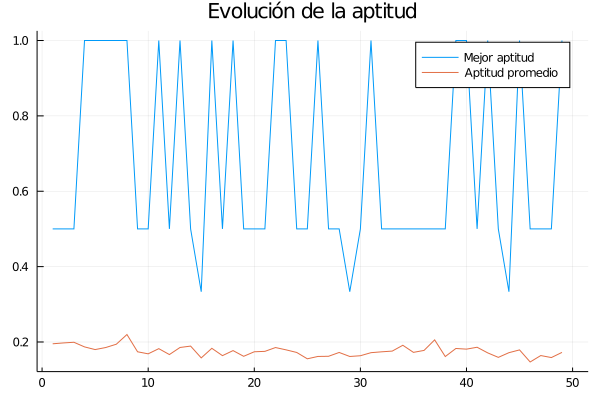

In [27]:
q2 = QueenSGA(8, 100, 1.0, 0.8)
data = collect_data(q2)
plot(data, title="Evolución de la aptitud", label=["Mejor aptitud" "Aptitud promedio"])

* Con su implementación resuelva el problema para $n=30$ reinas.

In [ ]:
q3 = QueenSGA(30, 100, 1.0, 0.8)
best = run(q3)
print("Genotipo: ", best, "\n")
print("Aptitud: ", apt(best), "\n")
print("Fenotipo: ")
build_board(best)